# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [6]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


tensorflow-gpu 2.0.0a0 has requirement numpy<2.0,>=1.14.5, but you'll have numpy 1.14.3 which is incompatible.
tensorflow-gpu 2.0.0a0 has requirement protobuf>=3.6.1, but you'll have protobuf 3.5.2 which is incompatible.
tensorboard 1.7.0 has requirement bleach==1.5.0, but you'll have bleach 3.2.1 which is incompatible.
tb-nightly 1.14.0a20190301 has requirement protobuf>=3.6.0, but you'll have protobuf 3.5.2 which is incompatible.
You are using pip version 19.0.3, however version 20.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [7]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



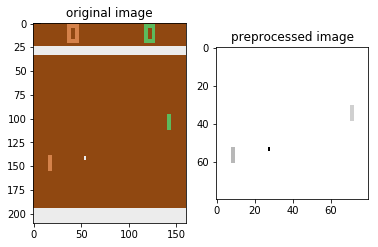

In [8]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [9]:
# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # 3 convolutional layers
        self.conv1 = nn.Conv2d(2, 8, kernel_size=16, stride=2)  # outsize: 8x33x33
        self.conv2 = nn.Conv2d(8, 8, kernel_size=8, stride=2)  # outsize: 8x13x13  # rounding down did work
        self.conv3 = nn.Conv2d(8, 8, kernel_size=4, stride=2)  # outsize: 8x5x5
        self.size = 8*5*5
        
        # 4 fully connected layers
        self.fc1 = nn.Linear(self.size, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        # apply conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # flatten the tensor
        x = x.view(-1, self.size)
        
        # apply fc layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return self.sig(self.fc3(x))

# use your own policy!
policy=Policy().to(device)


# policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


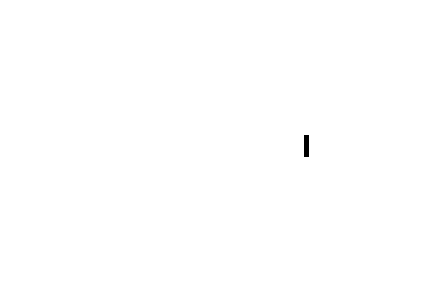
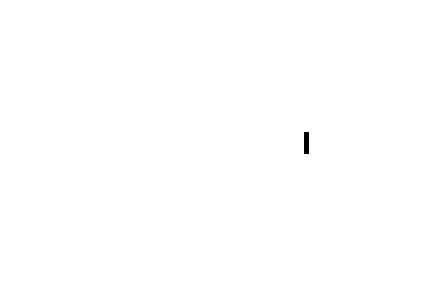
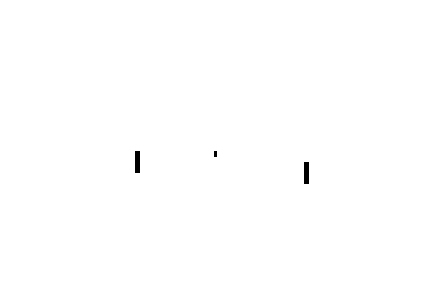
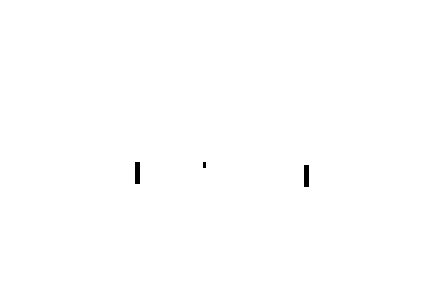
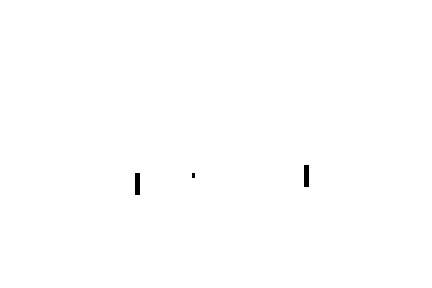
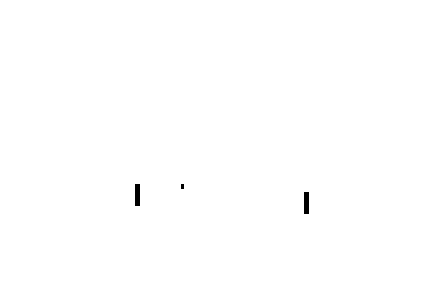
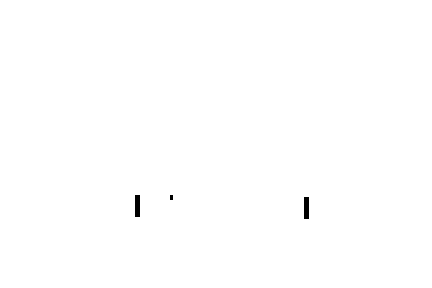
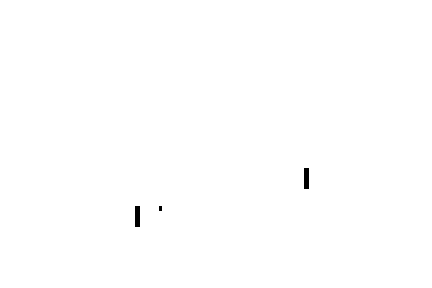
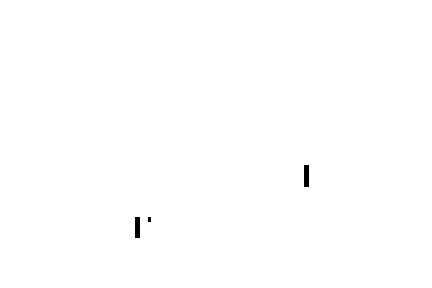
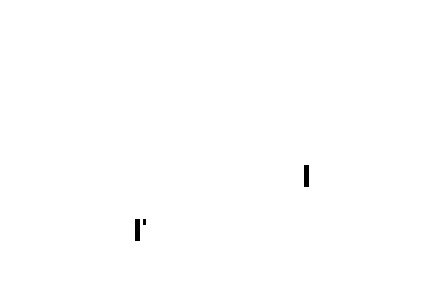
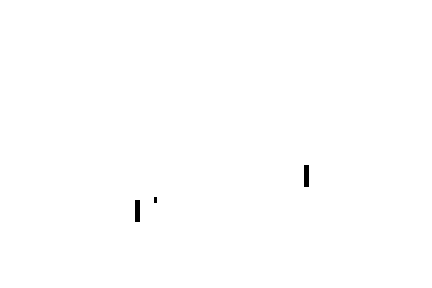
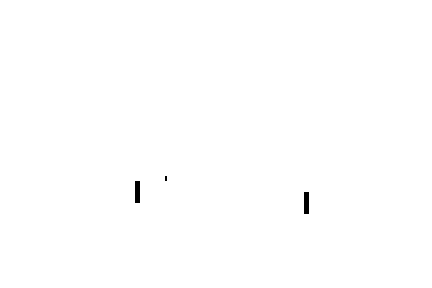
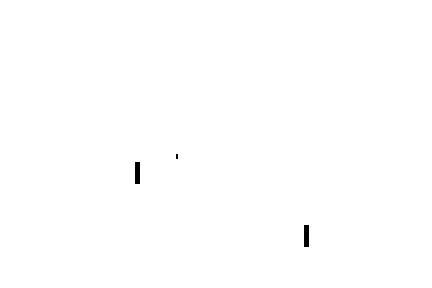
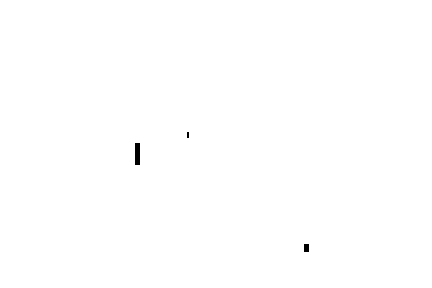
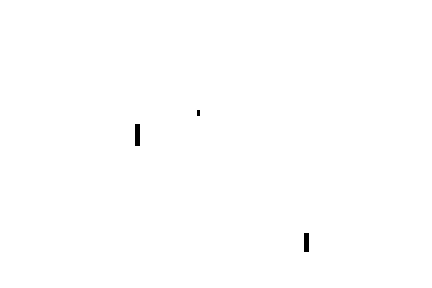
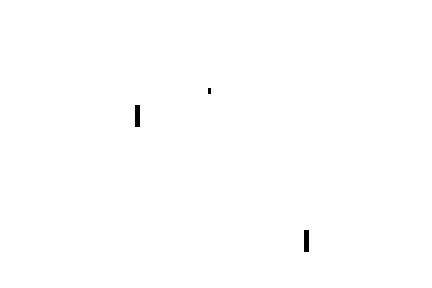
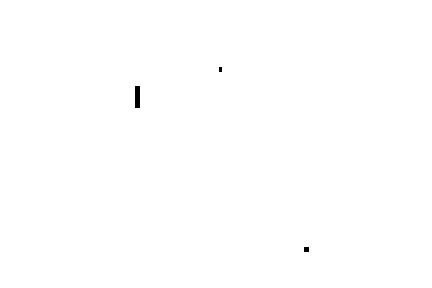
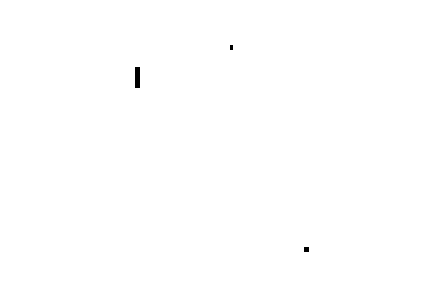
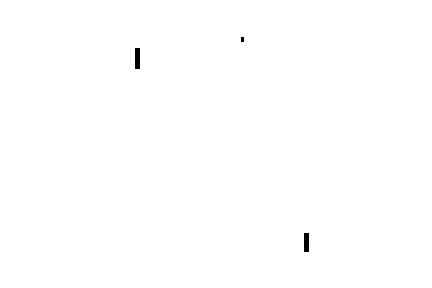
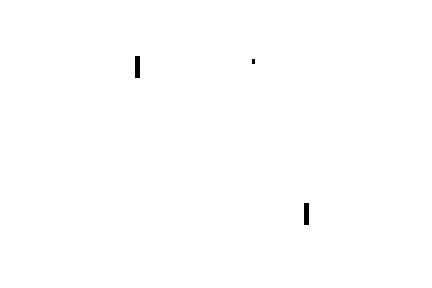
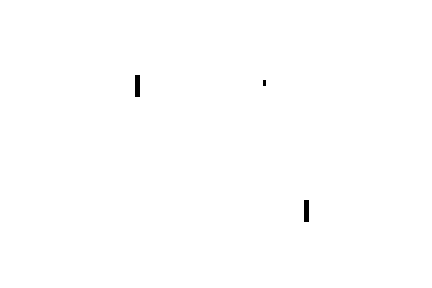
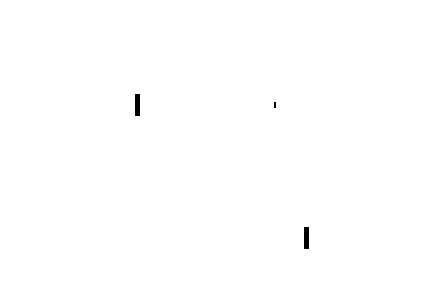
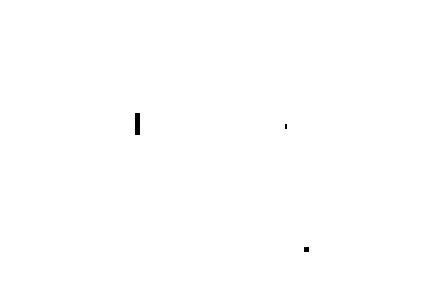
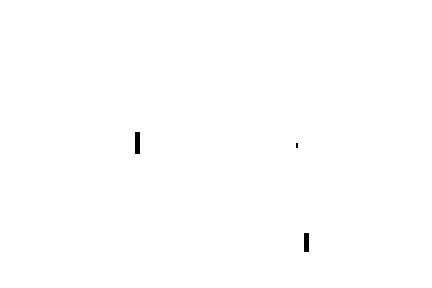
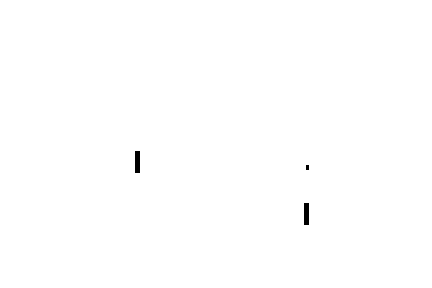
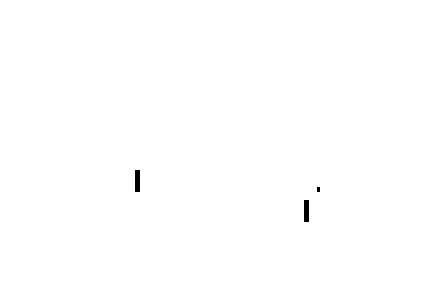
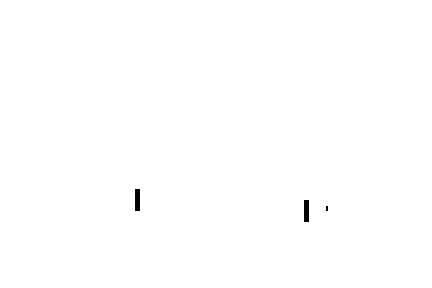
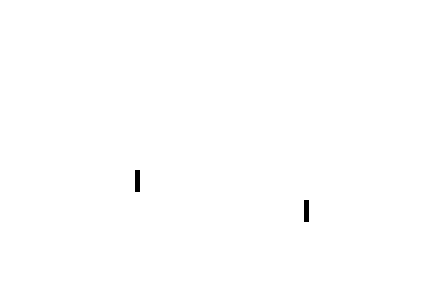
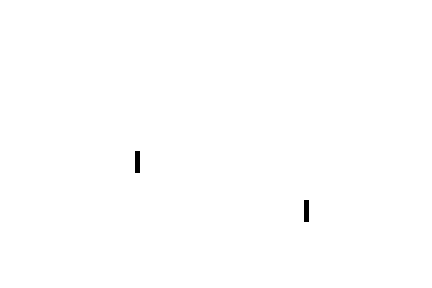
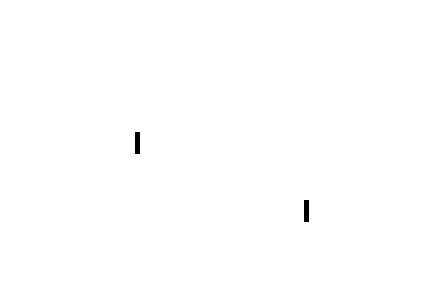
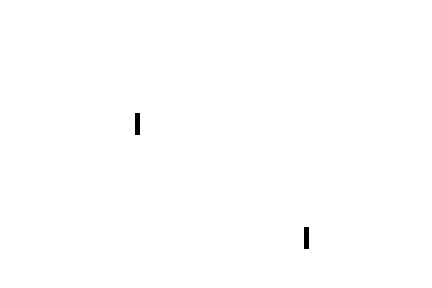
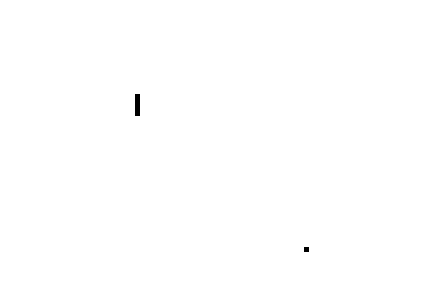
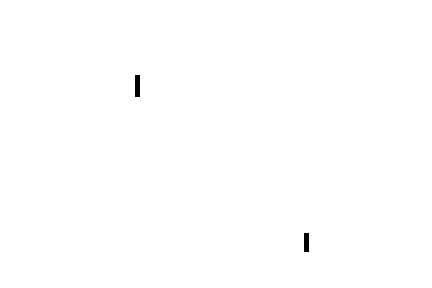
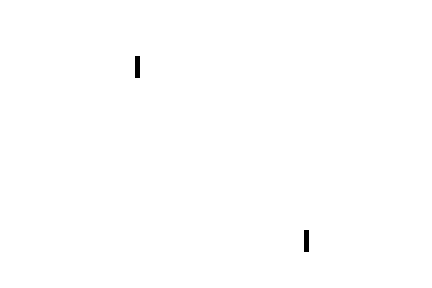
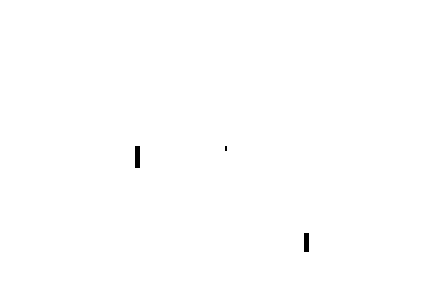
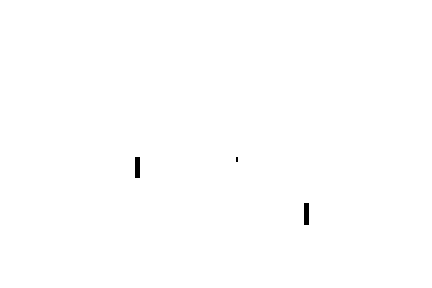
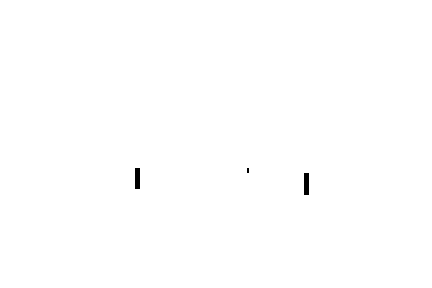
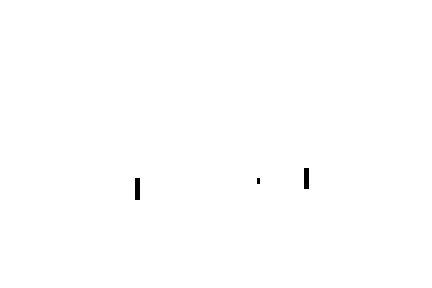
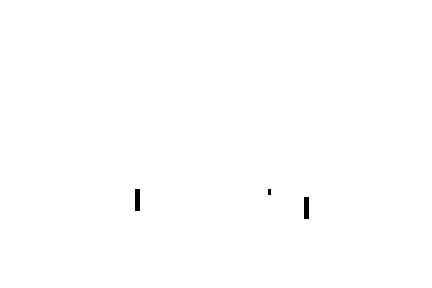
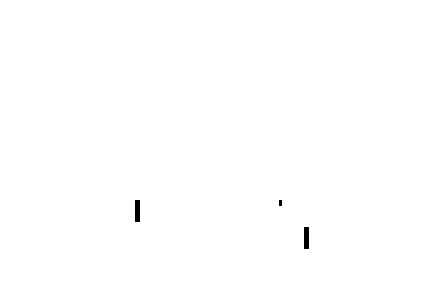
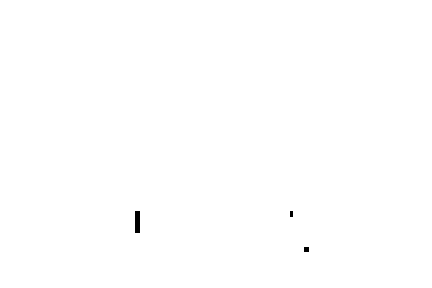
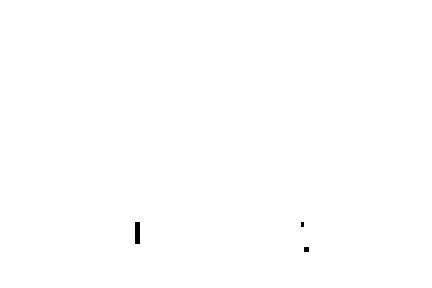
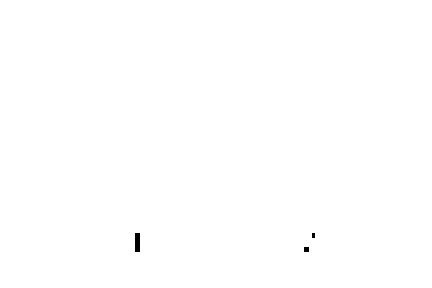
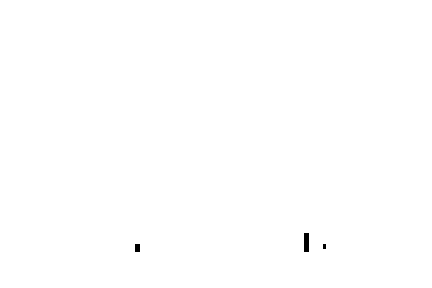
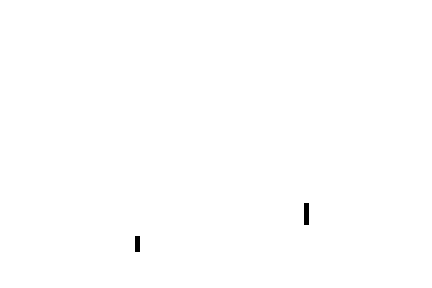
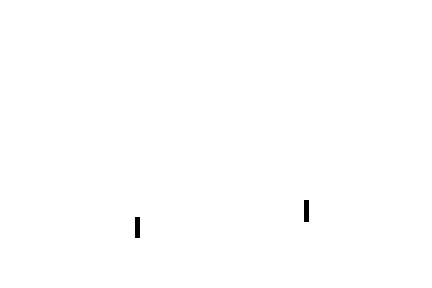
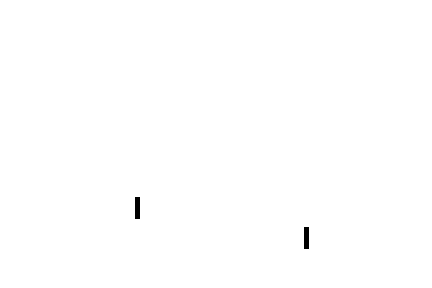
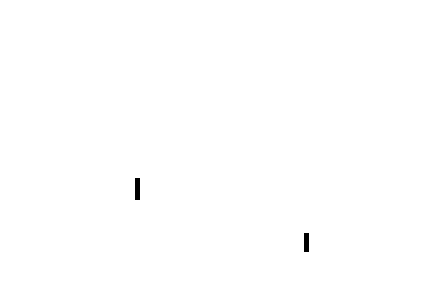
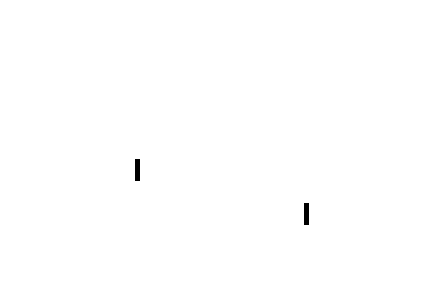
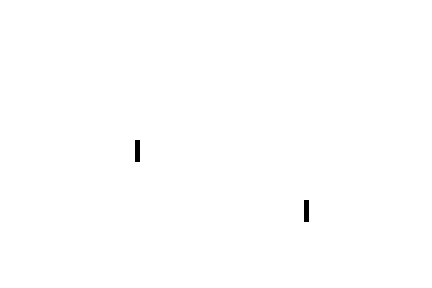
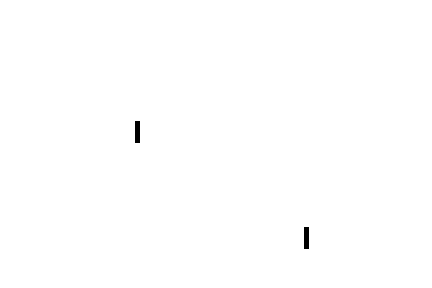
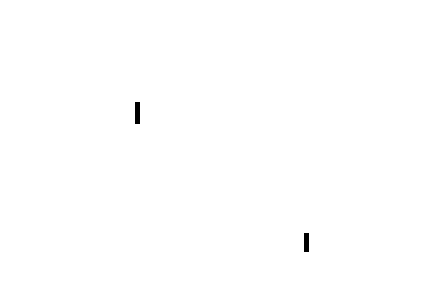
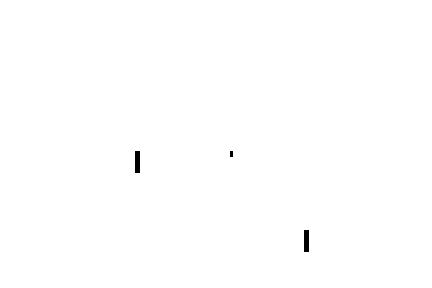
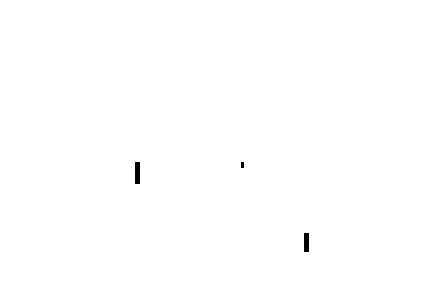
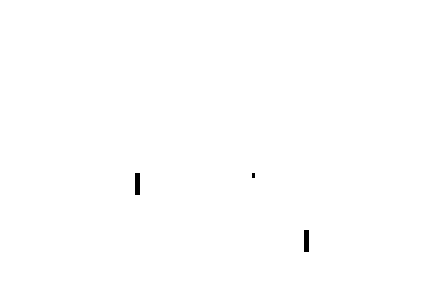
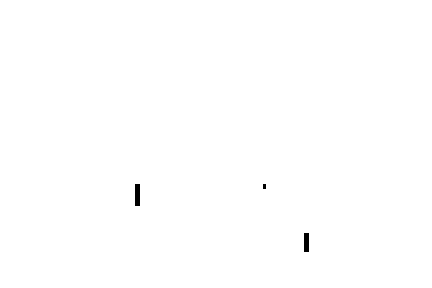
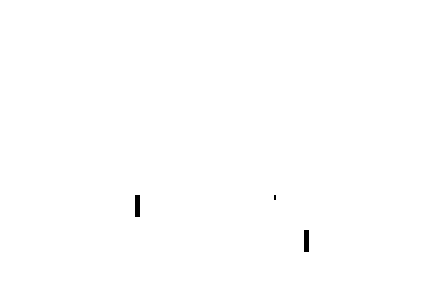
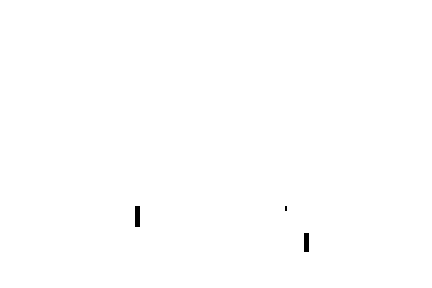
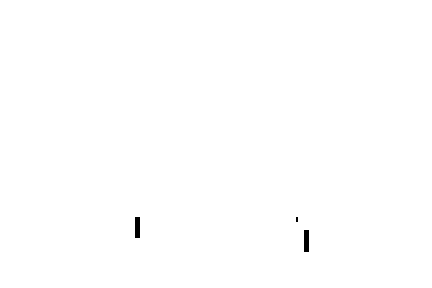
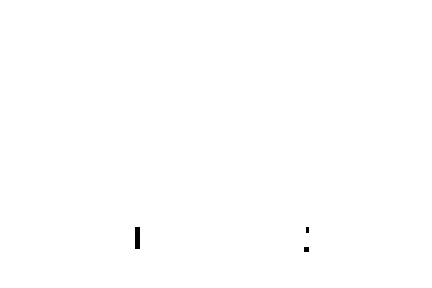
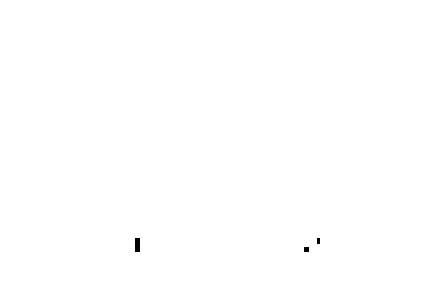
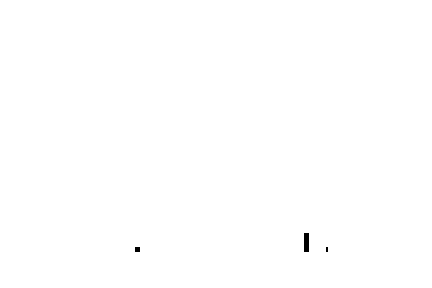
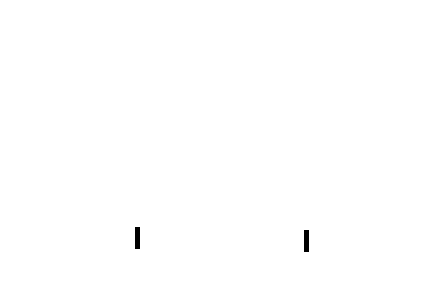
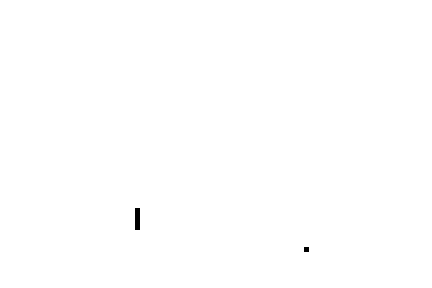
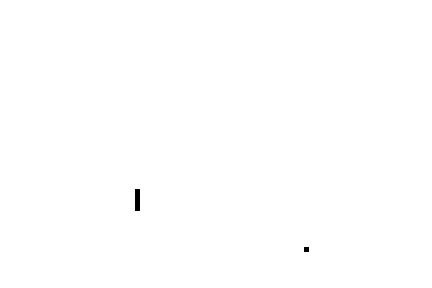
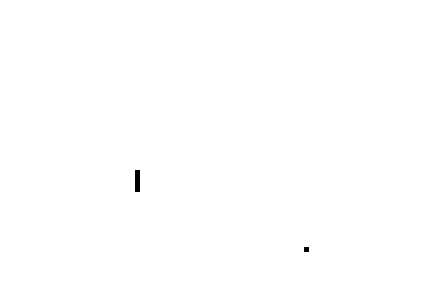
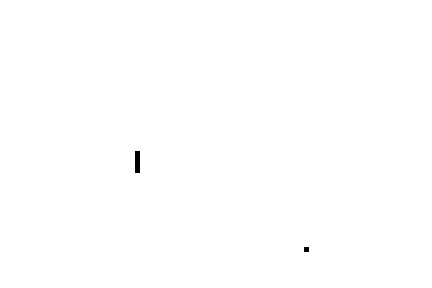
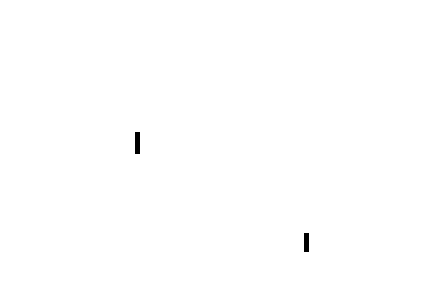
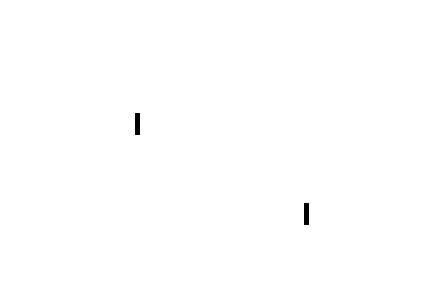
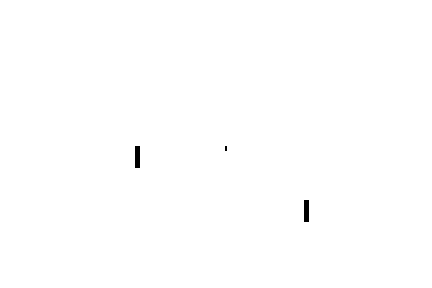
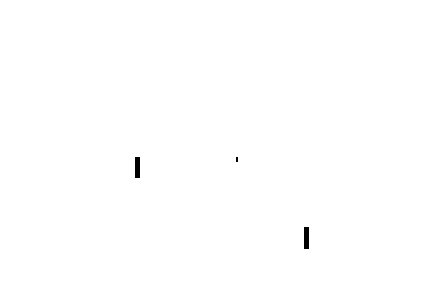
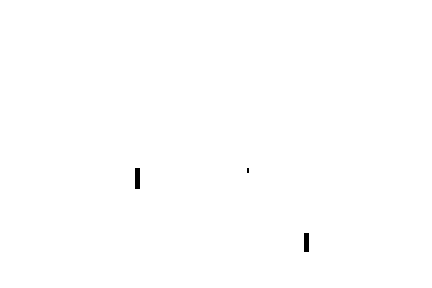
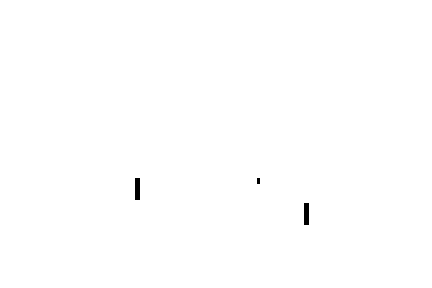
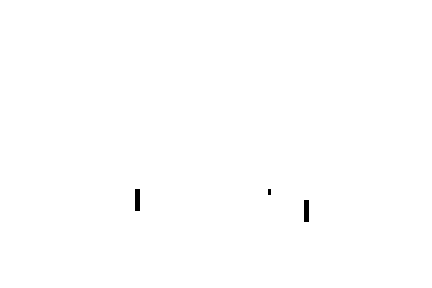
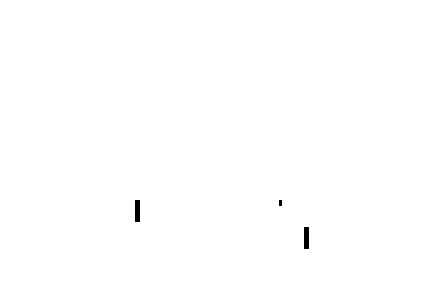
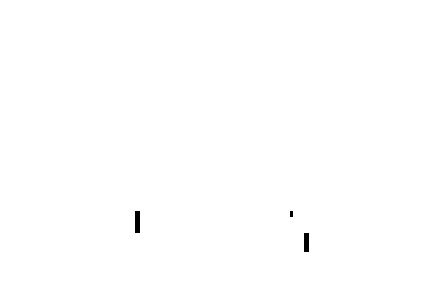
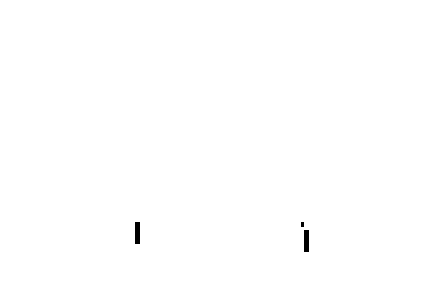
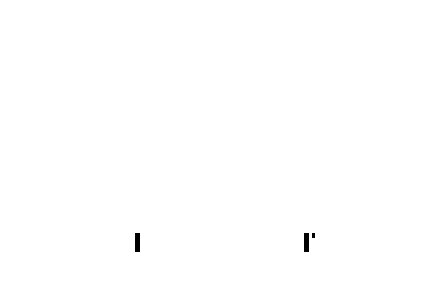
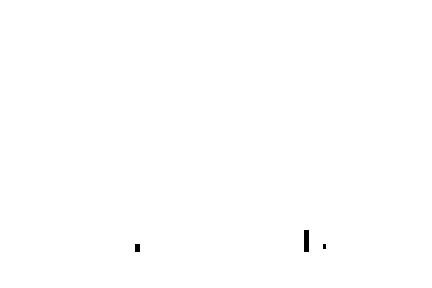
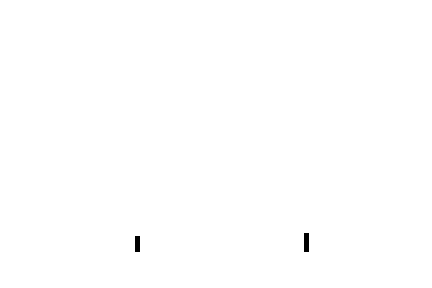
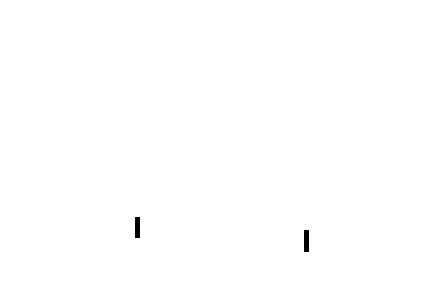
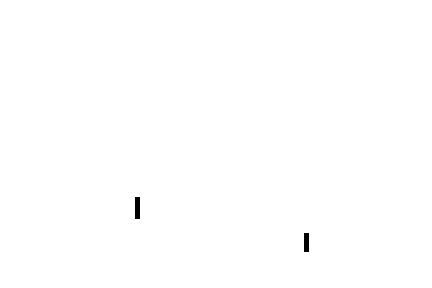
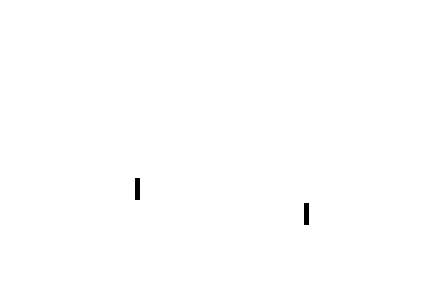
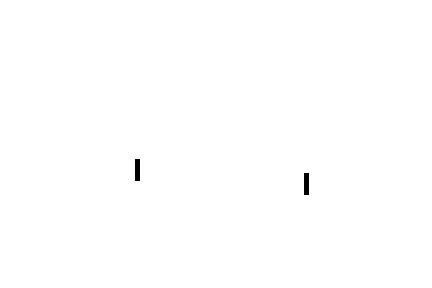
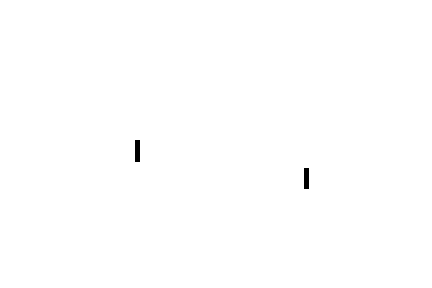
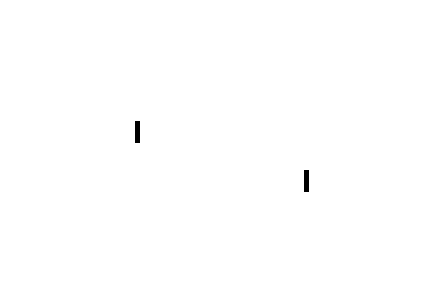
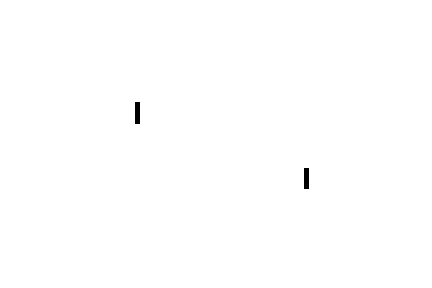
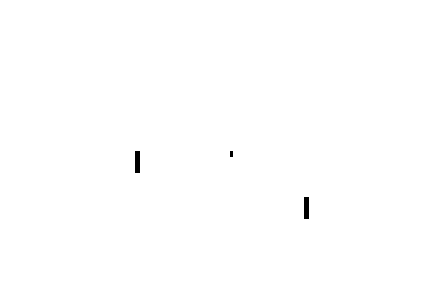
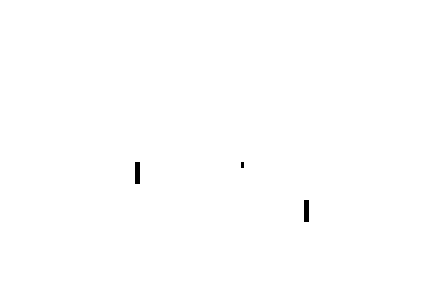
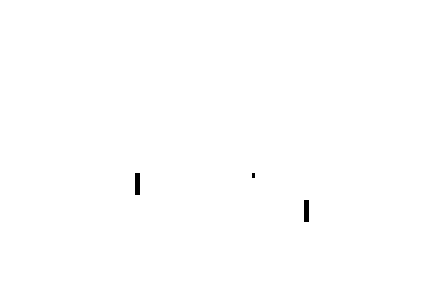
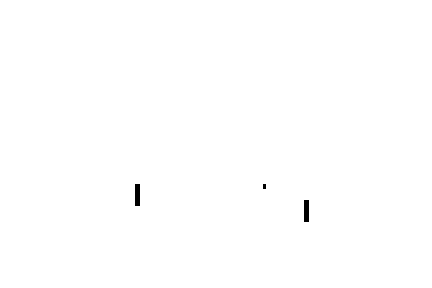
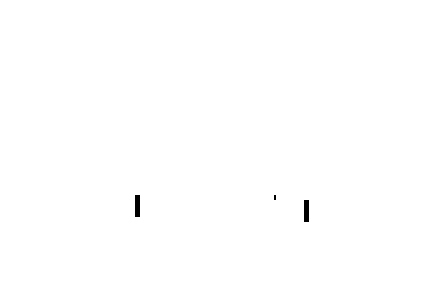
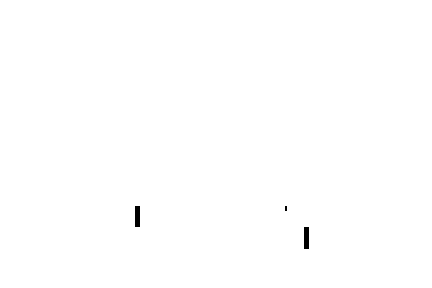
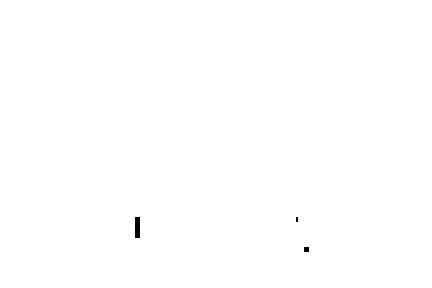
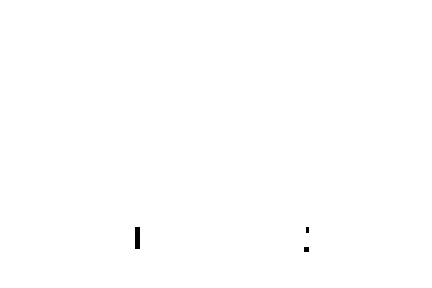
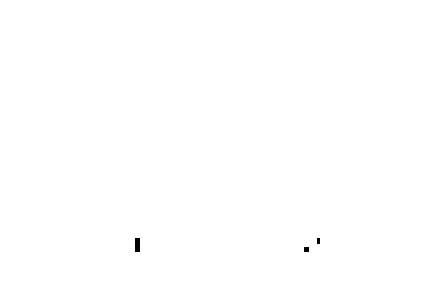
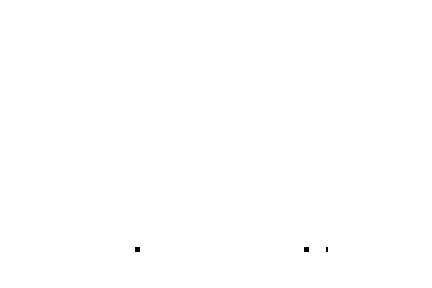
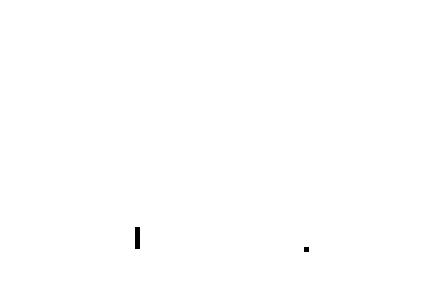
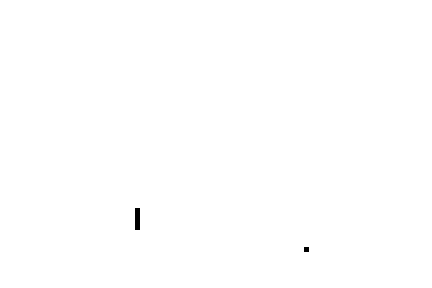
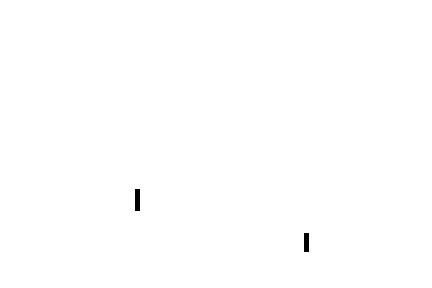
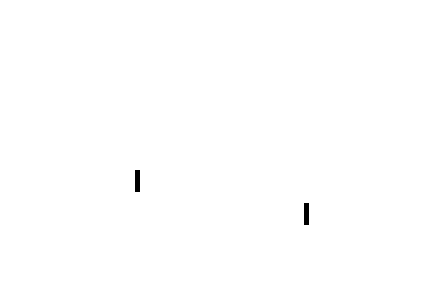
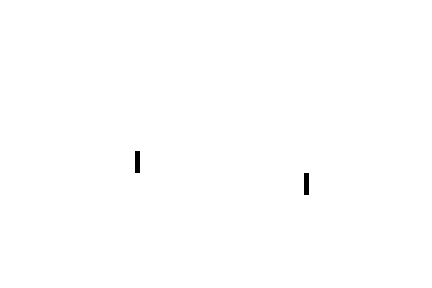
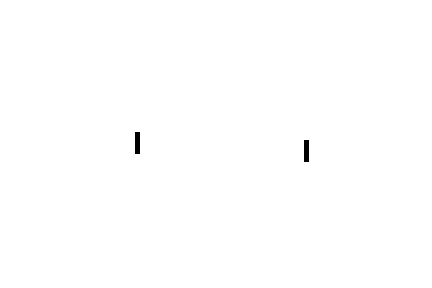
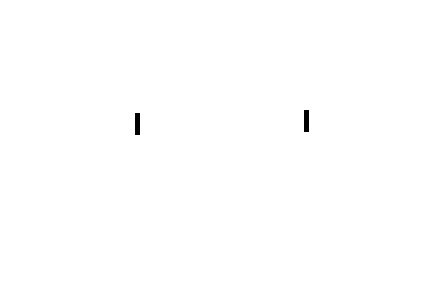
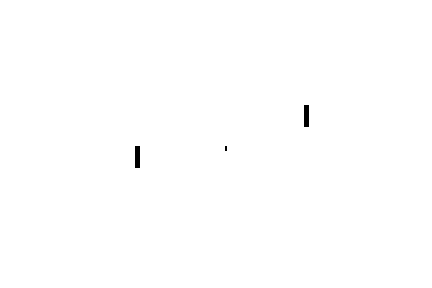
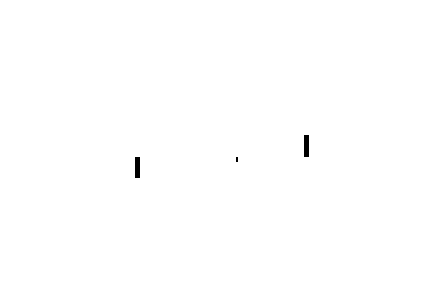
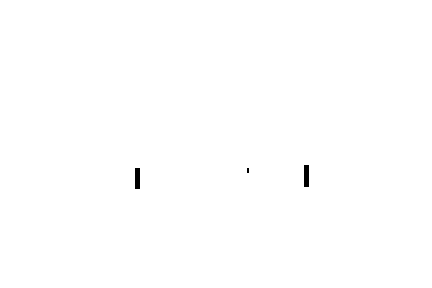
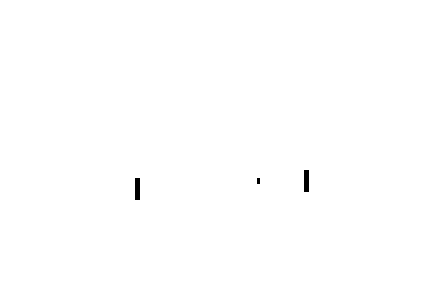
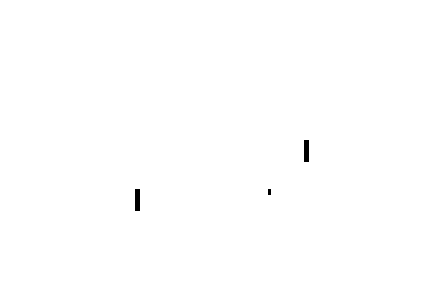
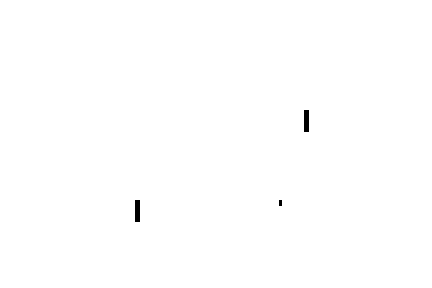
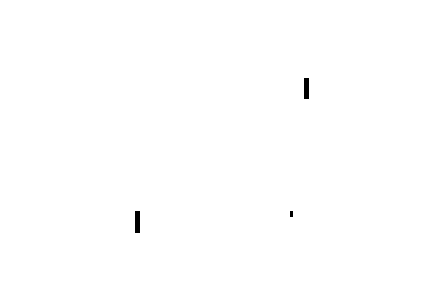
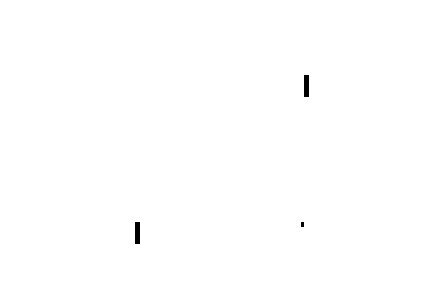
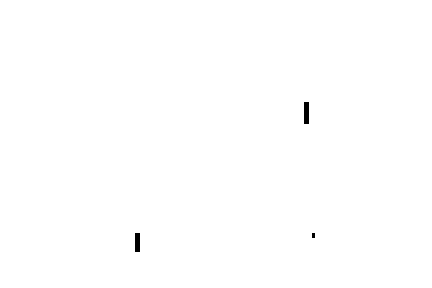
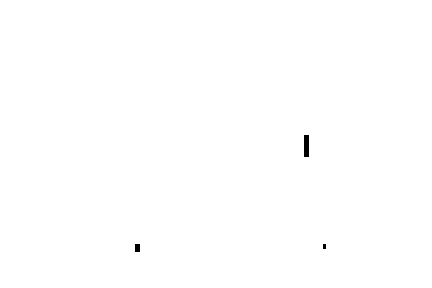
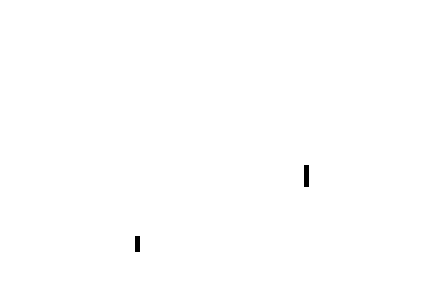
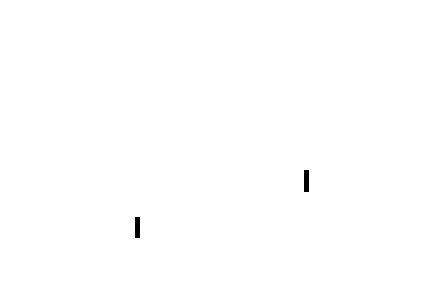
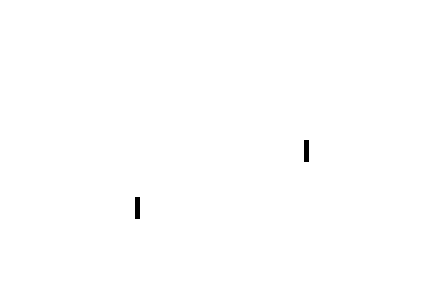
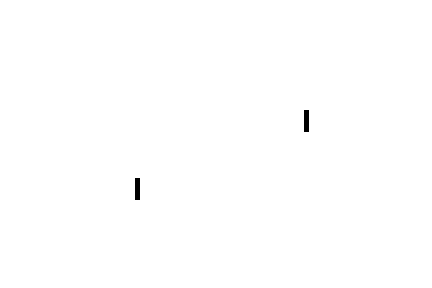
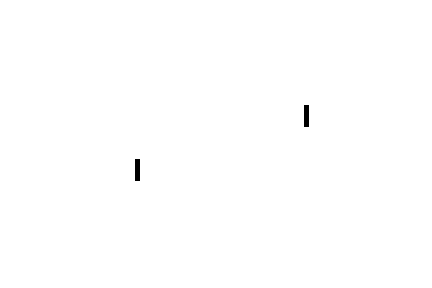
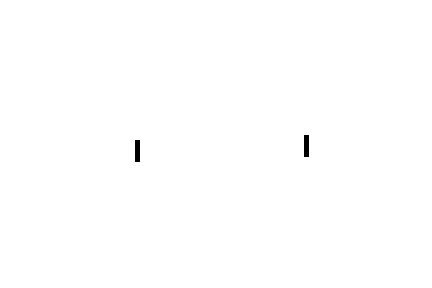
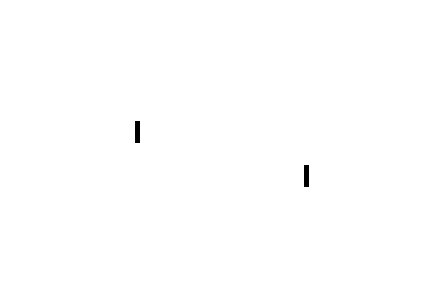
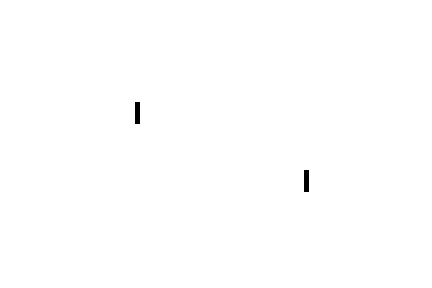
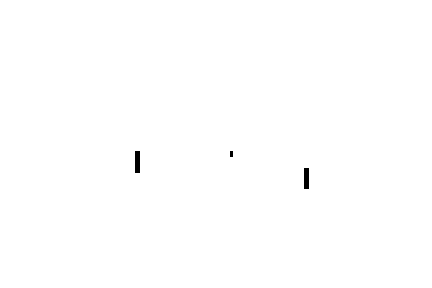
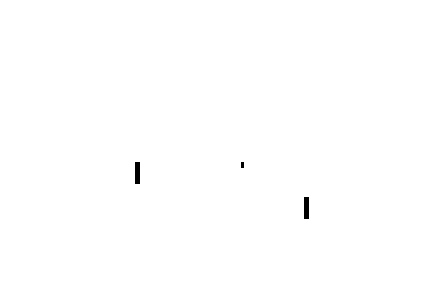
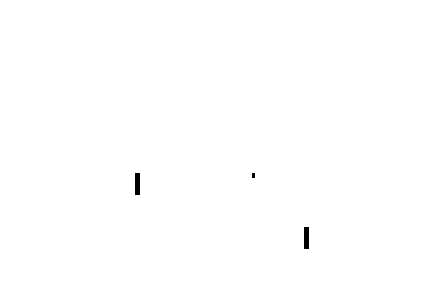
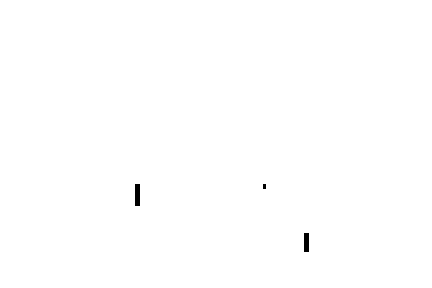
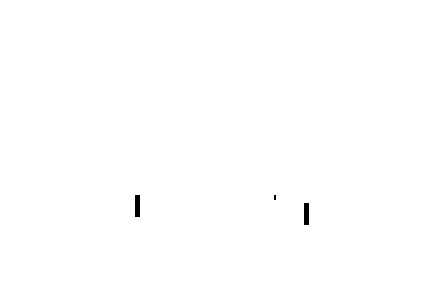
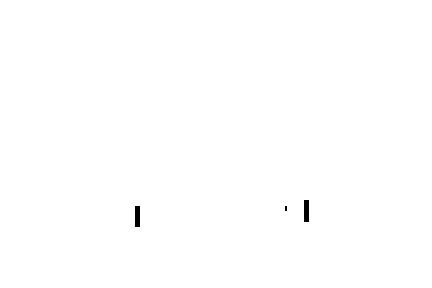
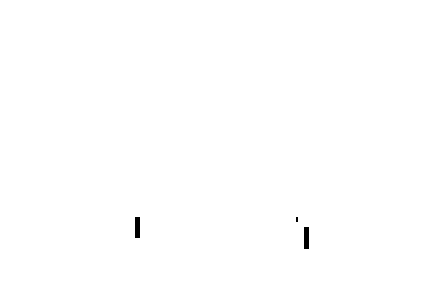
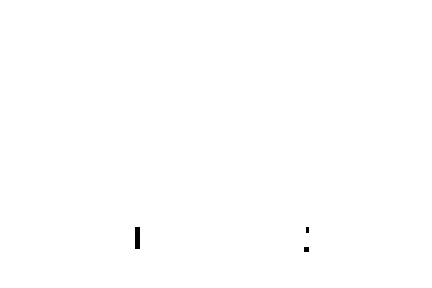
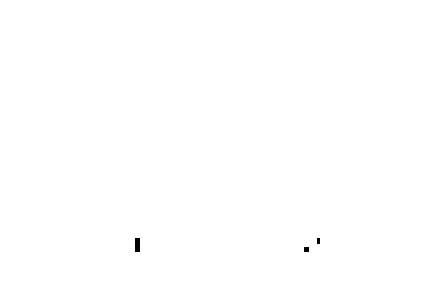
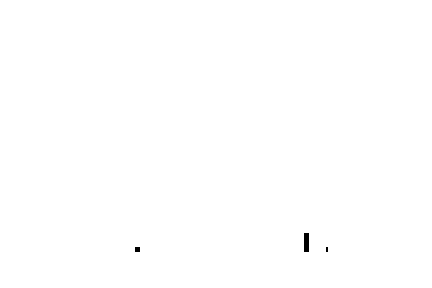
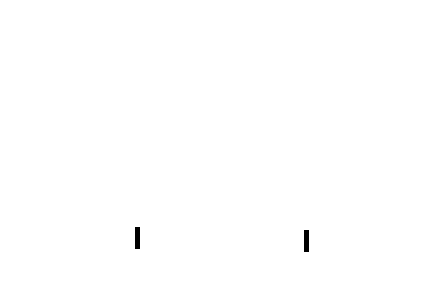
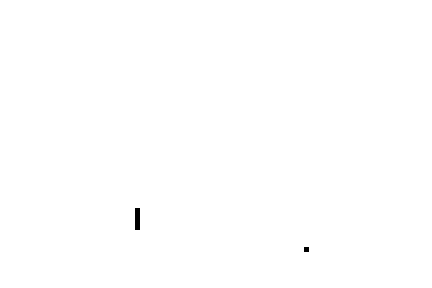
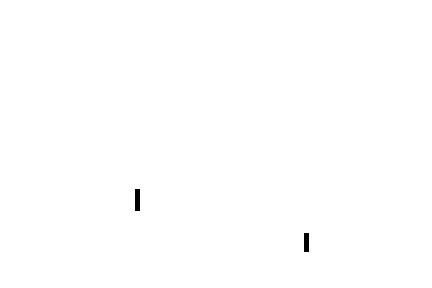
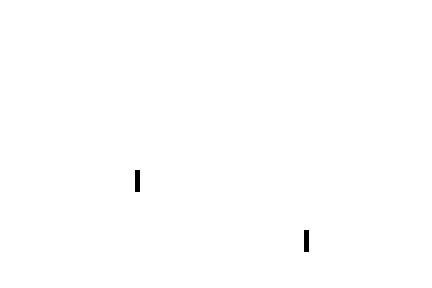
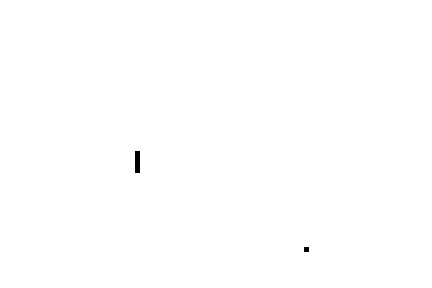
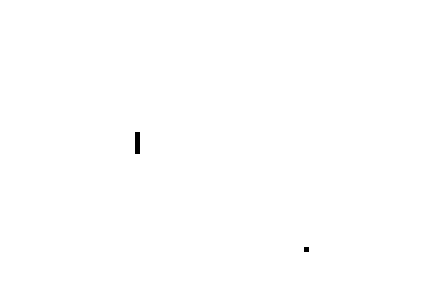
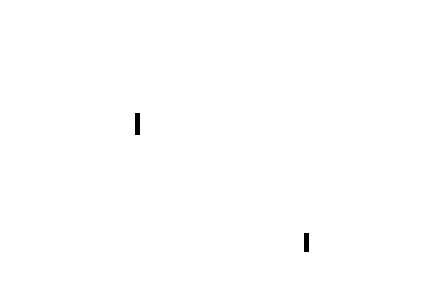
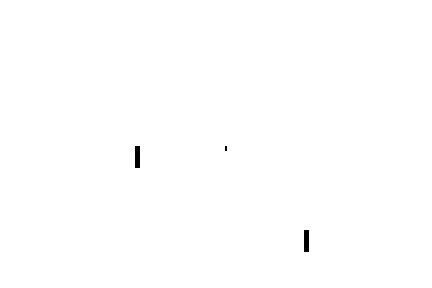
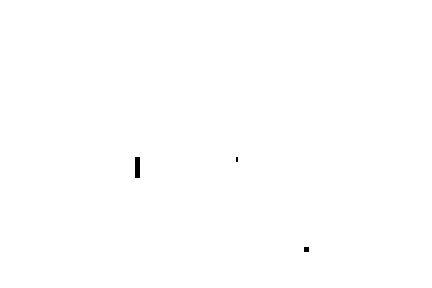
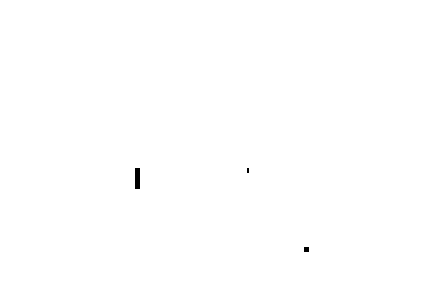
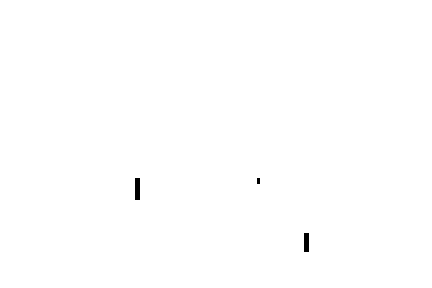
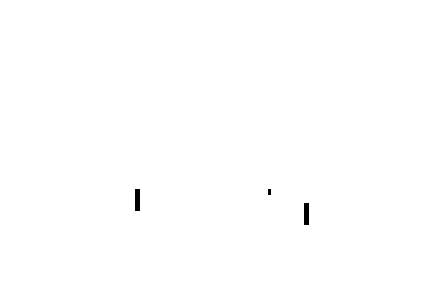
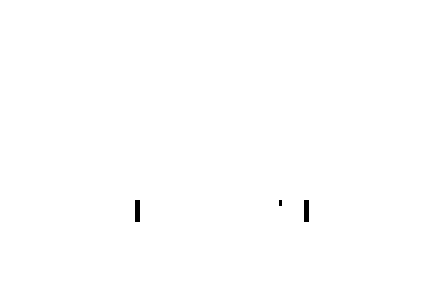
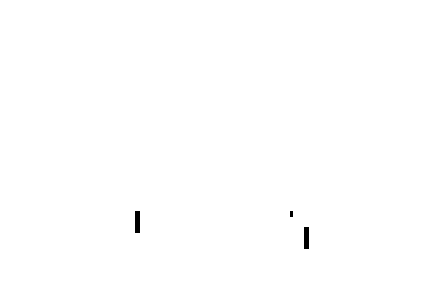
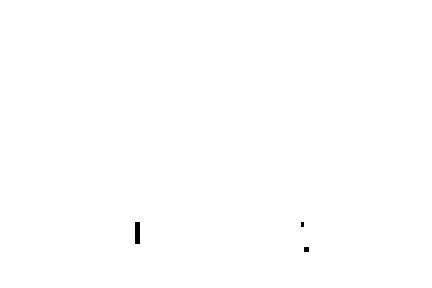
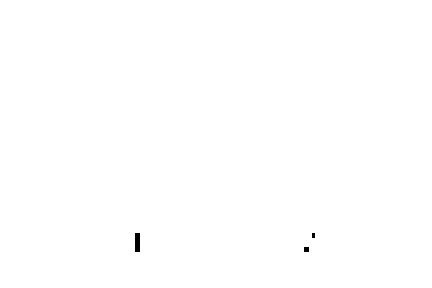
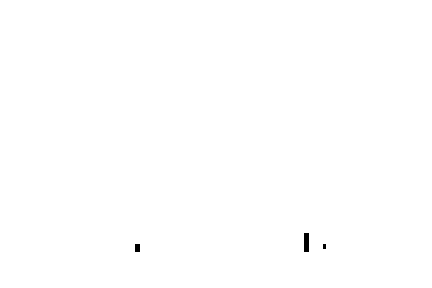
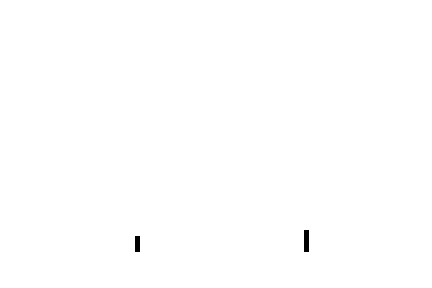
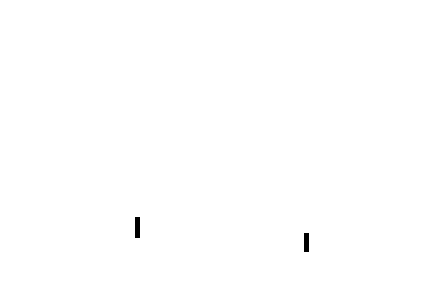
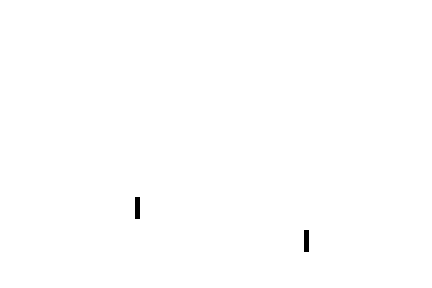
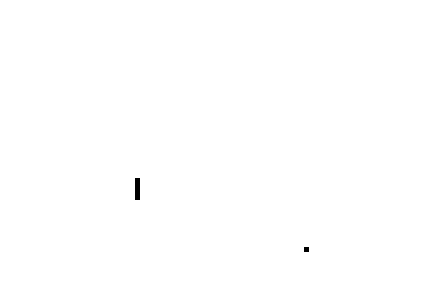
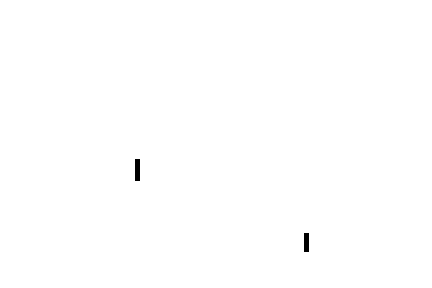
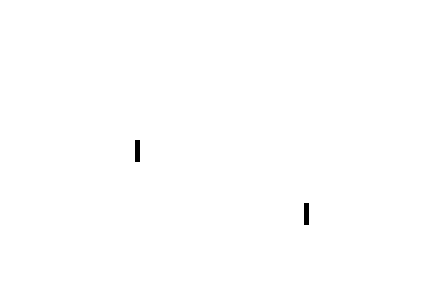
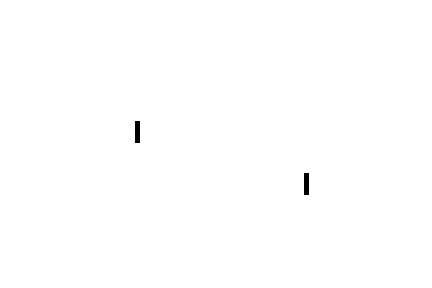
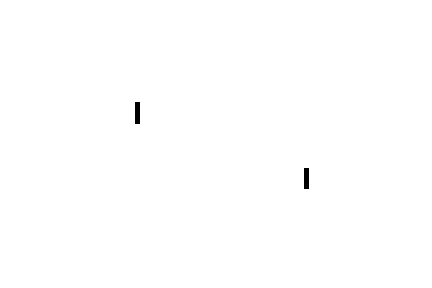
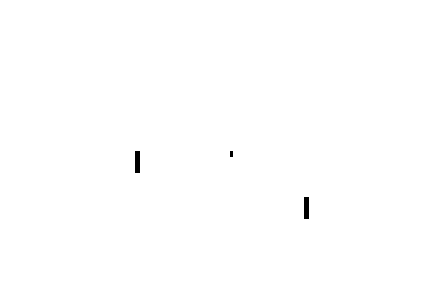
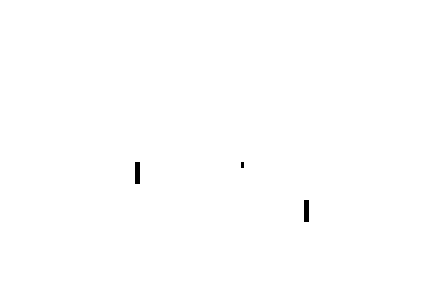
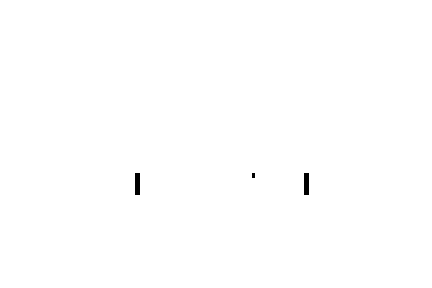
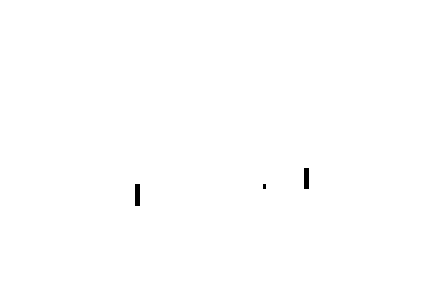
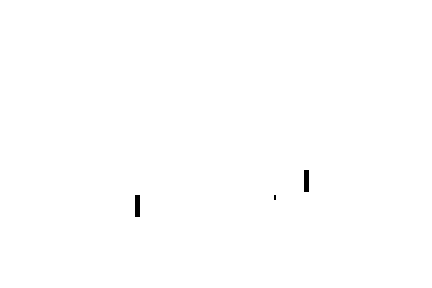
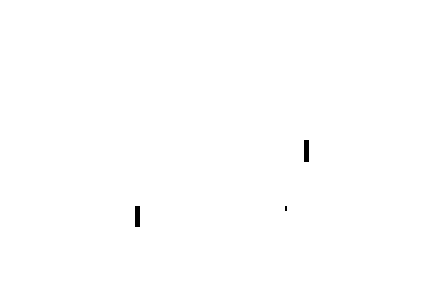
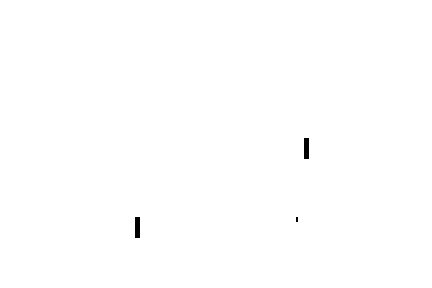
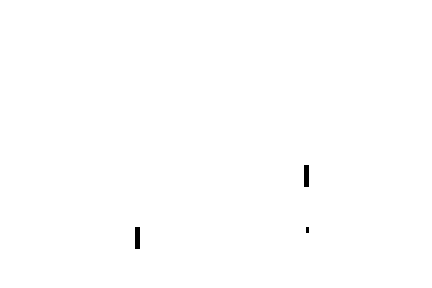
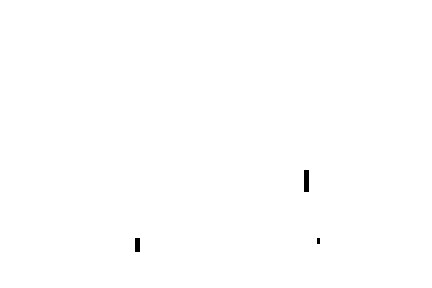
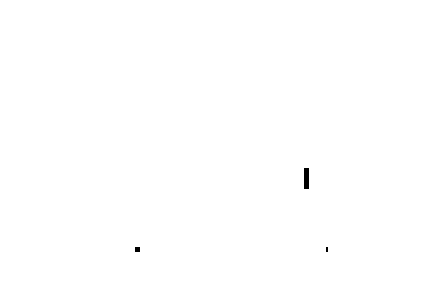
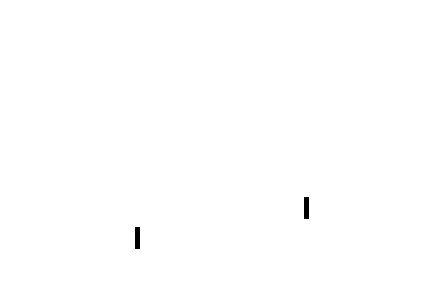
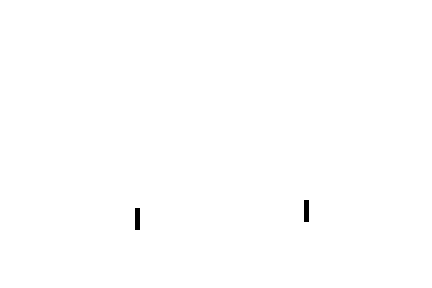
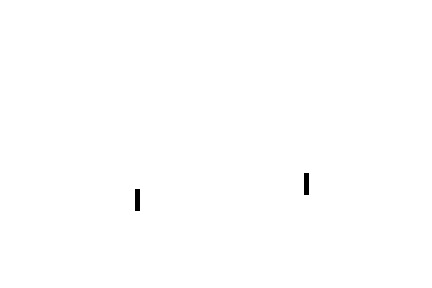
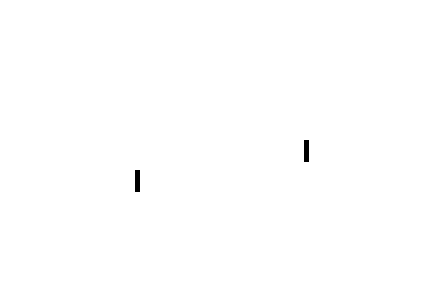
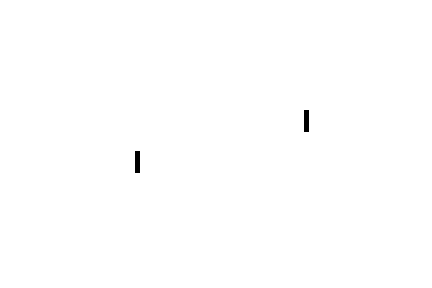
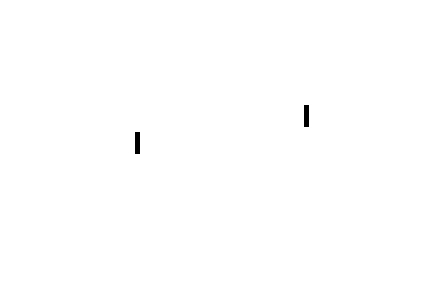
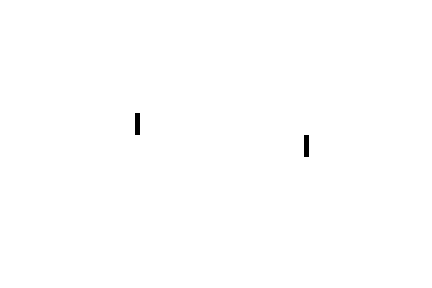
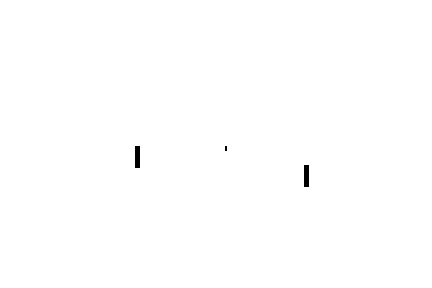
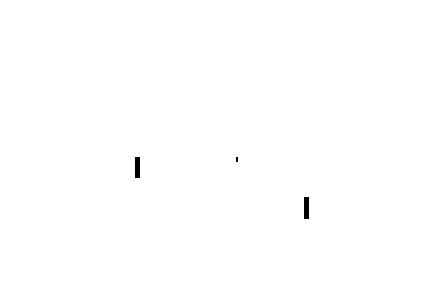
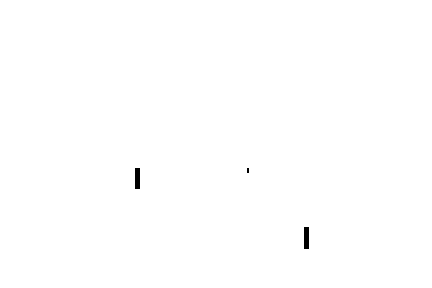
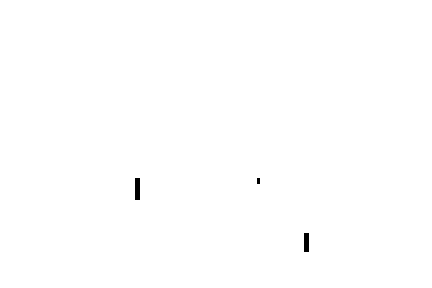
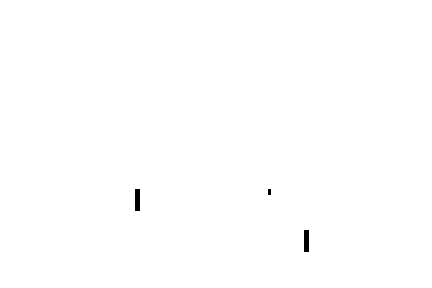
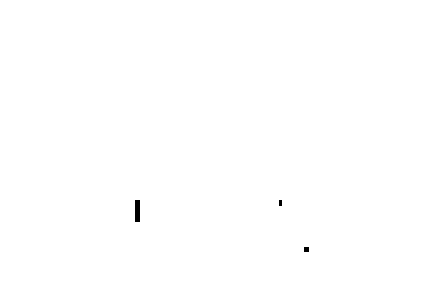
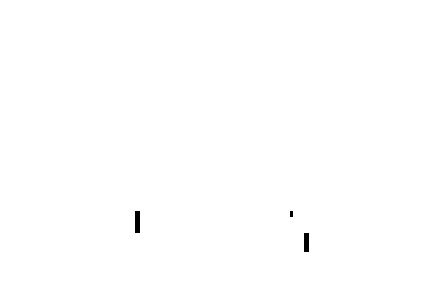
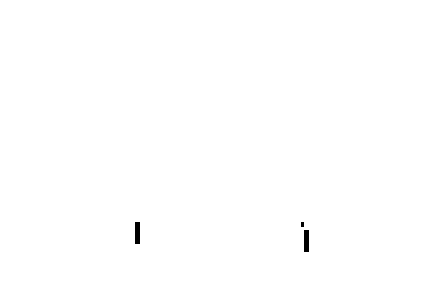
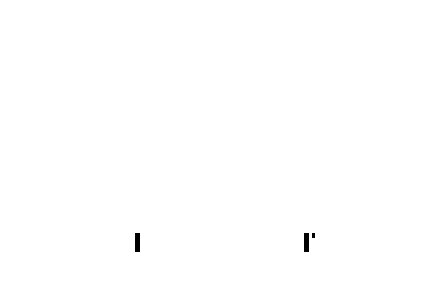
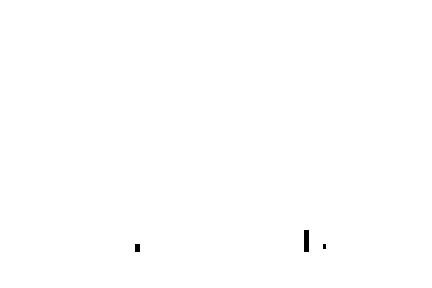
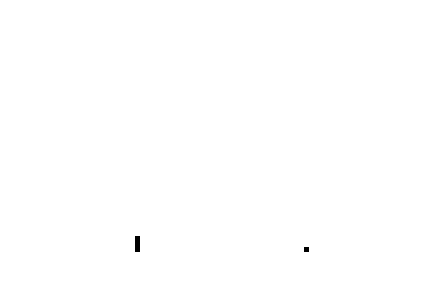
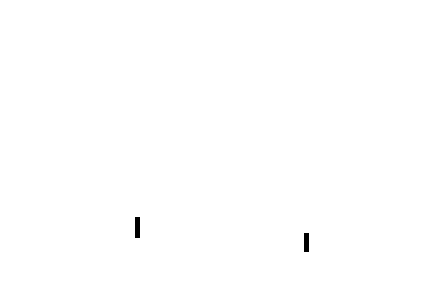
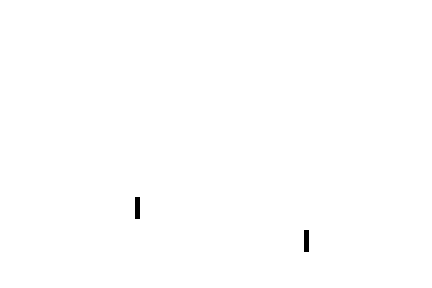
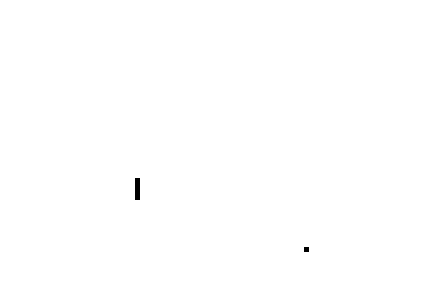
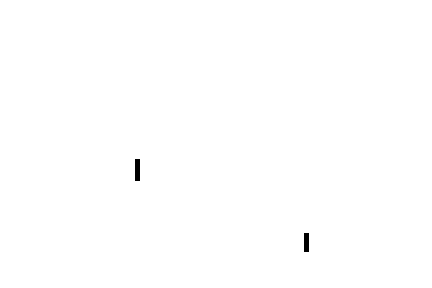
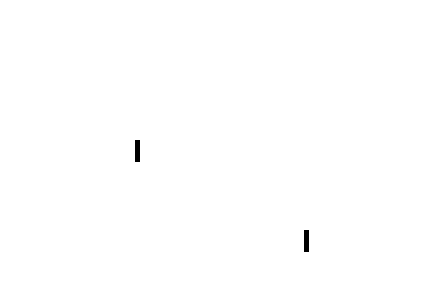
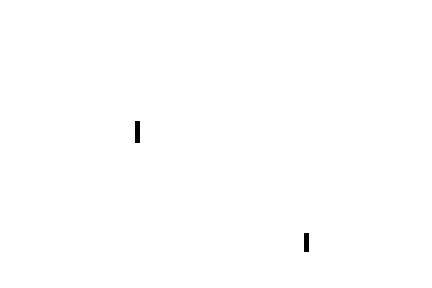
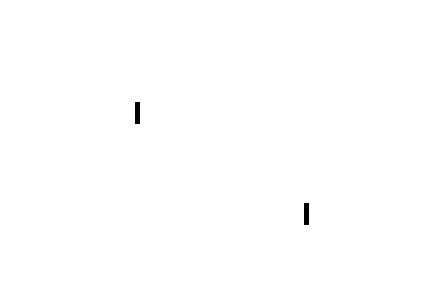
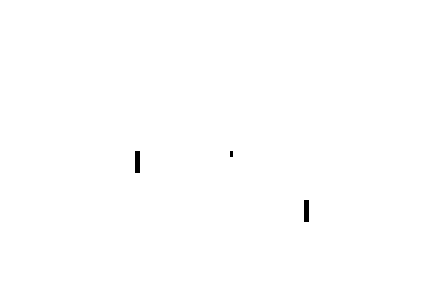
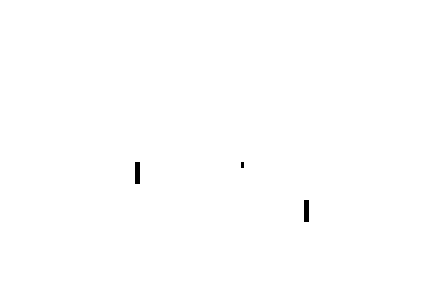
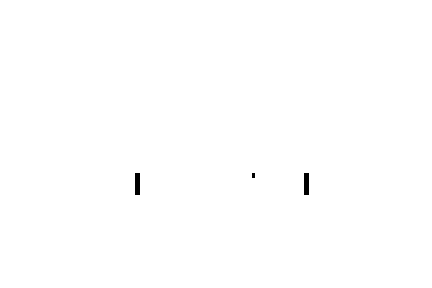
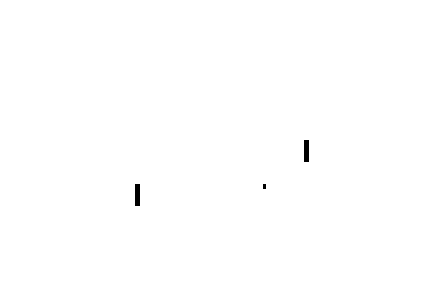
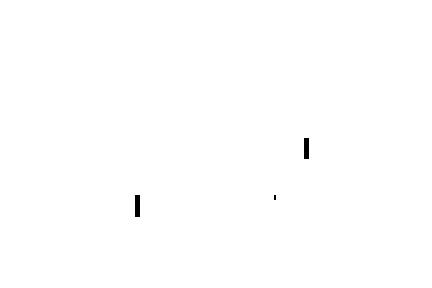
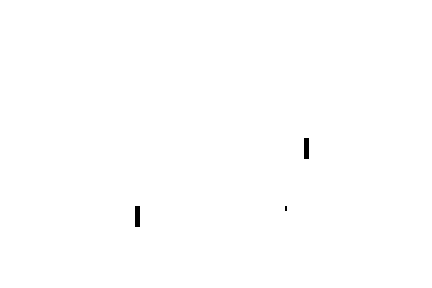
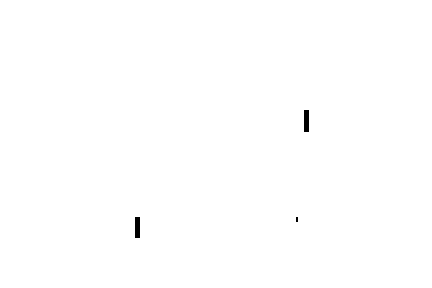
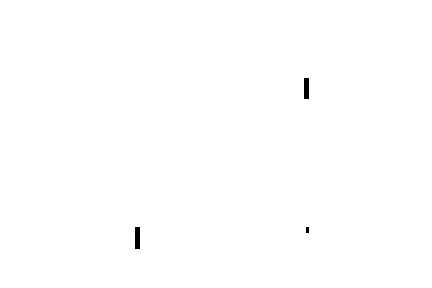

In [10]:
pong_utils.play(env, policy, time=200, preprocess=pong_utils.preprocess_single) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [11]:
from parallelEnv import parallelEnv
import numpy as np
envs = parallelEnv('PongDeterministic-v4', n=2, seed=1234)
tmax = 20
old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)

In [12]:
op = np.array(old_probs)
s = states[0]
a = np.array(actions)
r = np.array(rewards)

In [13]:
discount = 0.995

In [14]:
rewards = [np.ones(2) for i in range(tmax)]

In [15]:
r = np.array([rewards[i]*discount**i for i in range(len(rewards))])
print(r)

[[1.         1.        ]
 [0.995      0.995     ]
 [0.990025   0.990025  ]
 [0.98507488 0.98507488]
 [0.9801495  0.9801495 ]
 [0.97524875 0.97524875]
 [0.97037251 0.97037251]
 [0.96552065 0.96552065]
 [0.96069304 0.96069304]
 [0.95588958 0.95588958]
 [0.95111013 0.95111013]
 [0.94635458 0.94635458]
 [0.94162281 0.94162281]
 [0.93691469 0.93691469]
 [0.93223012 0.93223012]
 [0.92756897 0.92756897]
 [0.92293112 0.92293112]
 [0.91831647 0.91831647]
 [0.91372489 0.91372489]
 [0.90915626 0.90915626]]


In [16]:
r = np.array([rewards[i]*discount**i for i in range(tmax)])  # [tmax, nparal]
m = np.triu(np.ones((tmax, tmax), dtype=float))
rfuture = np.matmul(m, r)

In [17]:
r_future_normal = (rfuture - rfuture.mean(1)[:, np.newaxis])/(rfuture.std(1)[:, np.newaxis]+1e-5)
r_future_normal

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [18]:
r_future = torch.tensor(r_future_normal, dtype=torch.float32)
r_future

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [19]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):
    
    tmax = len(rewards)
    
    # calculate normalized future rewards
    r = np.array([rewards[i]*discount**i for i in range(tmax)])  # [tmax, nparal]
    m = np.triu(np.ones((tmax, tmax), dtype=float))
    r_future = np.matmul(m, r)
    r_future_normal = (r_future - r_future.mean(1)[:, np.newaxis])/(r_future.std(1)[:, np.newaxis]+1e-10)
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float32, device=device)
    r_future = torch.tensor(r_future_normal, dtype=torch.float32, device=device)
    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs).to(device)

    ratio = new_probs/old_probs
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*r_future, clip*r_future)
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy + clipped_surrogate)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [ ]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 400
SGD_epoch = 6

# keep track of progress
mean_rewards = []
mean_L = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)
    total_L_per_e = 0.


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        # L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
          #                                epsilon=epsilon, beta=beta)
        
        total_L_per_e += L.cpu().detach().numpy()
        
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
        
    mean_L.append(total_L_per_e/SGD_epoch)
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}, L: {2:f}".format(e+1,
                                                      np.mean(total_rewards),
                                                      np.mean(mean_L)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

tensorflow-gpu 2.0.0a0 has requirement numpy<2.0,>=1.14.5, but you'll have numpy 1.14.3 which is incompatible.
tensorflow-gpu 2.0.0a0 has requirement protobuf>=3.6.1, but you'll have protobuf 3.5.2 which is incompatible.
tensorboard 1.7.0 has requirement bleach==1.5.0, but you'll have bleach 3.2.1 which is incompatible.
tb-nightly 1.14.0a20190301 has requirement protobuf>=3.6.0, but you'll have protobuf 3.5.2 which is incompatible.
You are using pip version 19.0.3, however version 20.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
pong_utils.play(env, policy, time=200) 

In [ ]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 